### MMM Data Exploration and Curation
The purpose of this notebook is to explore and lightly curate the monthly min/mean/max (MMM) seaward landfast ice edge (SLIE) products for all three 9-year summary periods. These data have been identified as high-value summary products by the involved PIs. The data are split into two geographic zones: the Beaufort Sea and the Chukchi Sea.

In [1]:
from pathlib import Path

import eda as eda
from luts import ice_zones, ice_eras, mmm_pixel_values
from config import INPUT_DIR, BEAUFORT_DIR, CHUKCHI_DIR
from preprocess import tap_reproject_mmm_raster

In [2]:
print(f"The three summary periods are {ice_eras}")

The three summary periods are ['1996-2005', '2005-2014', '2014-2023']


In [3]:
# there are loads of different directories in the data source provided by the PIs
# and per conversation with them we want to look in the following locations for the high value MMM summary products
mmm_data_paths = []
for region in ice_zones:
    for era in ice_eras:
        mmm_data_paths.append(Path(INPUT_DIR / region / "AllSeasonsAnalysis2023" / f"MonthlySLIEs_{era}"))

# check a few target directories        
print(mmm_data_paths[0], "\n", mmm_data_paths[-1])

# there should be six directories: 3 eras * 2 zones = 6
assert len(mmm_data_paths) == len(ice_eras) * len (ice_zones)

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005 
 /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023


In [4]:
# within each directory, get eyes on the data and check metadata for conformity
help(eda.test_geotiff_metadata_for_conformity)
help(eda.plot_random_sample)

Help on function test_geotiff_metadata_for_conformity in module eda:

test_geotiff_metadata_for_conformity(directory, geotiff_metadata=None, str_to_match=None)
    Test metadata of GeoTIFF files in a directory for conformity.
    Args:
        directory (pathlib.PosixPath): The directory containing GeoTIFF files.
        geotiff_metadata (tuple, optional): A tuple containing a list of GeoTIFF file names and a list of metadata objects. Defaults to None.
        str_to_match (str, optional): A string to match in the file name. Defaults to None.
    Returns:
        dict: A dictionary of metadata objects that do not conform to the random metadata object using the filename as the key.

Help on function plot_random_sample in module eda:

plot_random_sample(directory)
    Plot a single random sample of a GeoTIFF file from a directory.
    
    Args:
        directory (pathlib.PosixPath): The directory containing GeoTIFF files.
    Returns:
        None



/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005 is identical.


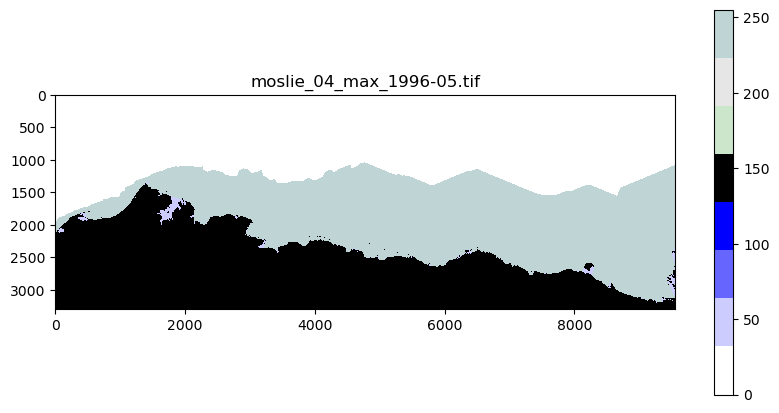

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014 is identical.


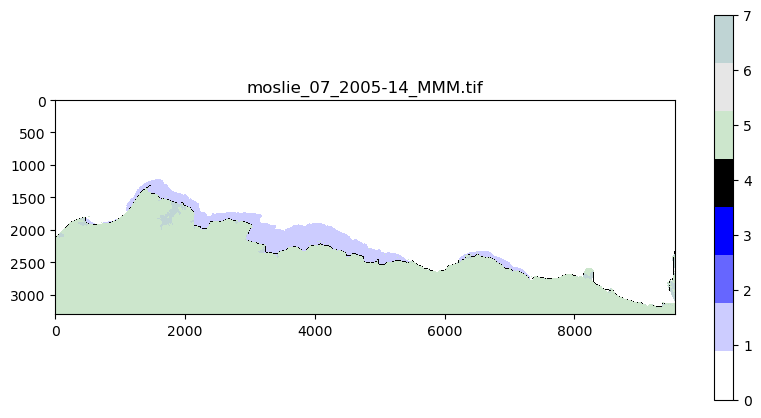

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023 is identical.


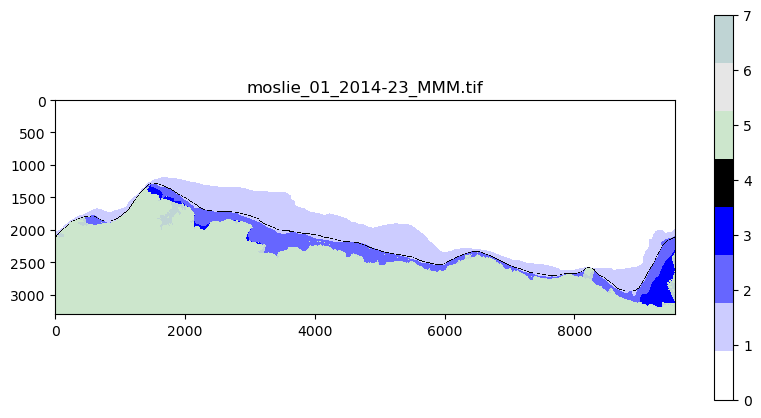

/beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005 is identical.


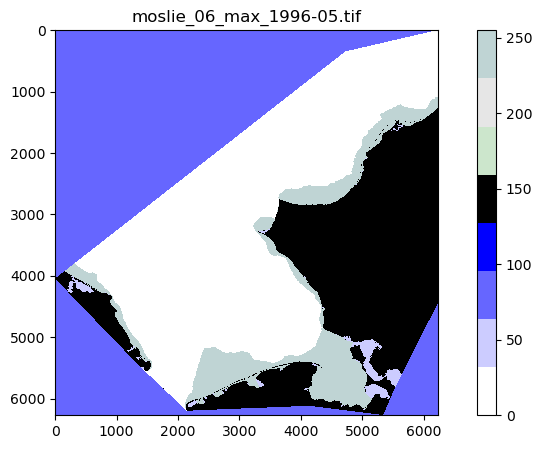

/beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2005-2014 is identical.


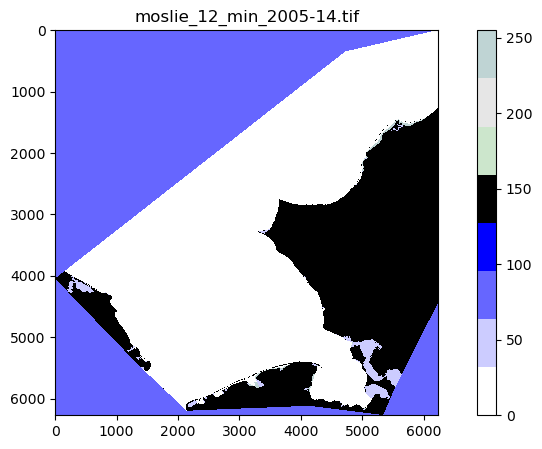

/beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023
All GeoTIFF metadata in /beegfs/CMIP6/cparr4/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023 is identical.


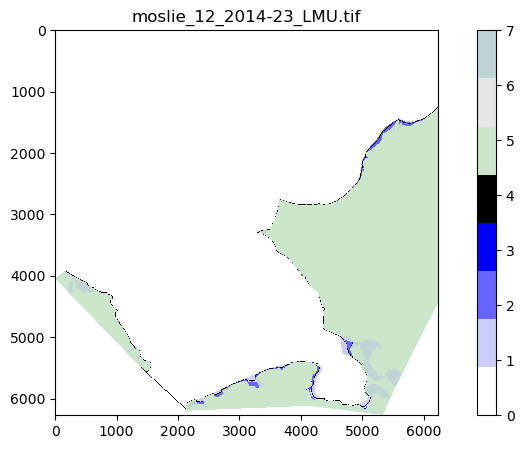

In [5]:
for directory in mmm_data_paths:
    print(directory)
    eda.test_geotiff_metadata_for_conformity(directory, geotiff_metadata=None, str_to_match="MMM")
    # add another loop if you want to see more plots
    eda.plot_random_sample(directory)

Great, so all the MMM metadata is identical. And we can see from the random sample plots (where we are **not** screening for `MMM` only data) some of the individual components of the MMM product: the minimum, the mean, and other dervied extents like `upp` and `LMU`. These more granular products are not needed at this time, but may become useful later on so it is good to know they are here. The next step is to separate out just the `MMM` GeoTIFFs.

In [6]:
# construct a list of the MMM GeoTIFFs across all six directories, ditto for the metadata
mmm_geotiffs_to_ingest = []
metas = []

for directory in mmm_data_paths: 
    tiffs = eda.list_geotiffs(directory, str_to_match="MMM")
    _, meta = eda.fetch_all_geotiff_metadata(directory, str_to_match="MMM")
    mmm_geotiffs_to_ingest = mmm_geotiffs_to_ingest + tiffs
    metas = metas + meta
    
# take a look at some metadata for a couple files
print(mmm_geotiffs_to_ingest[0], "\n", "\n", metas[0], "\n", "\n",)
print(mmm_geotiffs_to_ingest[-1], "\n", "\n", metas[-1], "\n", "\n",)

/beegfs/CMIP6/cparr4/landfast_sea_ice/Beau/AllSeasonsAnalysis2023/MonthlySLIEs_1996-2005/moslie_06_1996-05_MMM.tif 
 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9554, 'height': 3298, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(100.0, 0.0, -236180.0,
       0.0, -100.0, 2509919.0), 'blockxsize': 960, 'blockysize': 336, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'} 
 

/beeg

Ok so to highlight a few things in the metadata:

**'nodata': None** is a bit unusual. We'll want to verify that is the case.

**AUTHORITY["EPSG","4326"]]** - we'll want to reproject these data to EPSG 3338

**Affine(100.0, 0.0, -236180.0, 0.0, -100.0, 2509919.0)** these data have 100 m resolution - this is expected, but a far finer spatial resolution than we usually work with

**'compress': 'packbits'** not a common compression algorithm in my experience, so we might consider alternatives here

**'transform': Affine(100.0, 0.0, -859401.4481000006, 0.0, -100.0, 2423189.104800001)** - the Chukchi affine transformation has some floating point noise. We can trim this by reprojecting with a `target aligned pixels` parameter.

The reprojection to 3338 should be straightforward, and we'll want to double check whether or not these MMM summary data should have a prescribed nodata value and if we can consider a different compression algorithm.

In [7]:
print(f"All MMM values should conform to this set: {mmm_pixel_values}")

All MMM values should conform to this set: {0: 'Ocean', 1: 'Maximum Landfast Ice Extent', 2: 'Median Landfast Ice Extent', 3: 'Minimum Landfast Ice Extent', 4: 'Mean Landfast Ice Edge', 5: 'Land', 6: 'Out of Domain', 7: 'Coast Vector Shadow'}


In [8]:
mmm_expected = list(mmm_pixel_values.keys())

for geotiff in mmm_geotiffs_to_ingest:
    assert eda.validate_values(geotiff, mmm_expected) == True

Great, all values match the expected set. I think to just retain as much fidelity to the original research product, we won't prescribe a "no data" value here. One could argue that "Out of Domain" is a good candidate, but we can omit it for now.

Based on this EDA and some ad hoc testing, we've defined a function to handle the reprojection of these MMM rasters.

In [9]:
help(tap_reproject_mmm_raster)

Help on function tap_reproject_mmm_raster in module preprocess:

tap_reproject_mmm_raster(file)
    Reprojects a raster file to a new coordinate reference system (CRS) and aligns it to a target resolution.
    1. Opens the input raster file.
    2. Computes the new affine transformation, width, and height for the target CRS and resolution.
    3. Aligns the target affine transformation to the specified resolution.
    4. Updates the raster profile with the new CRS, transformation, dimensions, and compression settings.
    5. Creates a new raster file name based on the input file name.
    6. Reprojects the input raster data to the new CRS and writes it to the output file.
    The output raster file is saved with LZW compression.
    
    Args:
        file (str): The path to the input raster file.
    Returns:
        None



In [10]:
# shouldn't take more than two minutes on the debug node
for tiff in mmm_geotiffs_to_ingest:
    tap_reproject_mmm_raster(tiff)

We'll do a quick check to make sure that the outputs are there and are not horribly mangled.

In [11]:
!ls -lhrt $BEAUFORT_DIR

total 39K
-rw------- 1 cparr4 cmip6 179K Nov 20 08:12 Beaufort_06_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 163K Nov 20 08:12 Beaufort_07_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 192K Nov 20 08:12 Beaufort_04_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 189K Nov 20 08:12 Beaufort_05_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 195K Nov 20 08:12 Beaufort_03_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 194K Nov 20 08:12 Beaufort_02_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 186K Nov 20 08:12 Beaufort_12_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 180K Nov 20 08:12 Beaufort_11_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 189K Nov 20 08:12 Beaufort_01_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 172K Nov 20 08:12 Beaufort_10_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 192K Nov 20 08:12 Beaufort_04_2005-2014_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 178K No

In [12]:
!ls -lhrt $CHUKCHI_DIR

total 31K
-rw------- 1 cparr4 cmip6 238K Nov 20 08:13 Chukchi_10_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 249K Nov 20 08:13 Chukchi_11_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 282K Nov 20 08:13 Chukchi_02_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 277K Nov 20 08:13 Chukchi_01_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 261K Nov 20 08:13 Chukchi_12_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 285K Nov 20 08:13 Chukchi_03_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 277K Nov 20 08:13 Chukchi_05_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 234K Nov 20 08:13 Chukchi_07_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 286K Nov 20 08:13 Chukchi_04_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 263K Nov 20 08:13 Chukchi_06_1996-2005_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 233K Nov 20 08:13 Chukchi_10_2005-2014_SLIE_MMM_summary.tif
-rw------- 1 cparr4 cmip6 246K Nov 20 08:13 

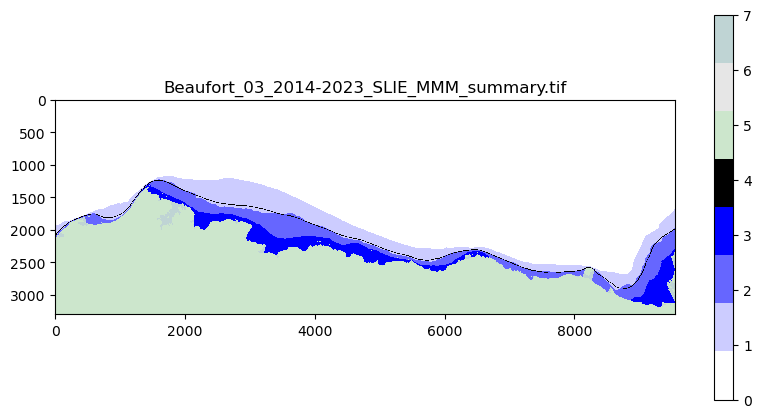

In [13]:
eda.plot_random_sample(BEAUFORT_DIR)

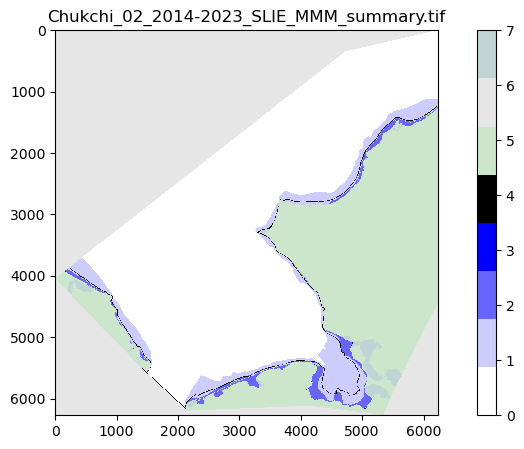

In [14]:
eda.plot_random_sample(CHUKCHI_DIR)

In [15]:
# number of files should 10 months * 3 era in each directory
assert len(eda.list_geotiffs(BEAUFORT_DIR)) == 30

In [16]:
assert len(eda.list_geotiffs(CHUKCHI_DIR)) == 30

AssertionError: 

In [17]:
print(len(eda.list_geotiffs(CHUKCHI_DIR)))

29


Well, after digging in the directory we see that there is simply no MMM product for July in the most recent era. Until we hear otherwise from the PI we assume that this is because there were not sufficient landfast ice detections during that period to justify generating a product. We print the July Chukchi MMM products and see there are only two files.

In [18]:
print([x for x in eda.list_geotiffs(CHUKCHI_DIR) if "07" in x.name])

[PosixPath('/beegfs/CMIP6/cparr4/landfast_sea_ice_products/Chukchi_MMM/Chukchi_07_1996-2005_SLIE_MMM_summary.tif'), PosixPath('/beegfs/CMIP6/cparr4/landfast_sea_ice_products/Chukchi_MMM/Chukchi_07_2005-2014_SLIE_MMM_summary.tif')]


In [19]:
!ls /beegfs/CMIP6/$USER/landfast_sea_ice/Chuk/AllSeasonsAnalysis2023/MonthlySLIEs_2014-2023 | grep MMM

moslie_01_2014-23_MMM.tif
moslie_02_2014-23_MMM.tif
moslie_03_2014-23_MMM.tif
moslie_04_2014-23_MMM.tif
moslie_05_2014-23_MMM.tif
moslie_06_2014-23_MMM.tif
moslie_10_2014-23_MMM.tif
moslie_11_2014-23_MMM.tif
moslie_12_2014-23_MMM.tif


The above cell confirms that there is no July 2014-2023 file within the original source dataset. We didn't miss anything.